In [1]:
import wellfare as wf
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
tecanfilename = "Tecan_file.xlsx"
parsed_sheets = wf.parse_tecan(tecanfilename)
wells = wf.merge_wells_dicts(parsed_sheets)

# Selected wells
cols = [8, 12]
rows = "EFGH"
colors = ['red', 'gold']

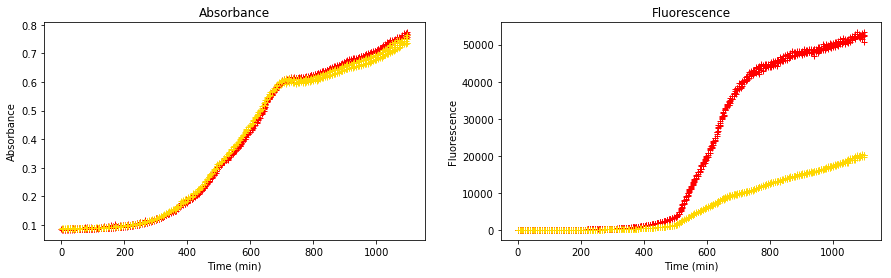

In [10]:
# Plot raw data
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].set_title('Absorbance')
ax[0].set_ylabel('Absorbance')
ax[0].set_xlabel('Time (min)')
ax[1].set_title('Fluorescence')
ax[1].set_ylabel('Fluorescence')
ax[1].set_xlabel('Time (min)')
for ir, r in enumerate(rows):
    for ic, c in enumerate(cols):
        wellname = r + str(c)
        wells[wellname]['Abs'].plot(
            ax=ax[0], marker='+', linewidth=1, linestyle='none', color=colors[ic])
        wells[wellname]['Fluo'].plot(
            ax=ax[1], marker='+', linewidth=1, linestyle='none', color=colors[ic])
plt.show()

In [11]:
# Removing background
absBackgroundLevel = .085
fluoRefWell = "H2"
method = "calibrationcurve"  # can be direct or calibrationcurve

TEST (203,) (203,) 150


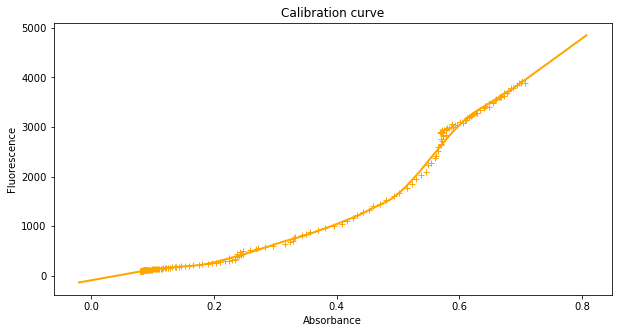

In [22]:
if method == "calibrationcurve":
    # Computes calibration curve (Fluo vs Abs of background well)
    calibration_curve, smooth_calibration_curve = wf.preprocessing.calibration_curve(
        wells[fluoRefWell]['Abs'], wells[fluoRefWell]['Fluo'], smoothing=150, extrapoldistance=0.1, validinterval=None)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    calibration_curve.plot(
        ax=ax, marker='+', linewidth=1, linestyle='none', color='orange')
    smooth_calibration_curve.plot(
        ax=ax, linewidth=2, linestyle='solid', color='orange')
    ax.set_title('Calibration curve')
    ax.set_ylabel('Fluorescence')
    ax.set_xlabel('Absorbance')
    plt.show()

In [21]:
for ir, r in enumerate(rows):
    for ic, c in enumerate(cols):
        # For Absorbance
        wellname = r + str(c)
        wells[wellname]["Abs-corrected"] = wells[wellname]['Abs'] - \
            absBackgroundLevel

        # For Fluorescence
        if method == "direct":
            # Direct Method (simple subtraction)
            wells[wellname]["Fluo-corrected"] = wells[wellname]['Fluo'] - \
                wells[fluoRefWell]['Fluo']

        if method == "calibrationcurve":
            # Calibration curve method
            Autofluo = smooth_calibration_curve(wells[wellname]['Abs'].y)
            wells[wellname]["Fluo-corrected"] = wells[wellname]['Fluo'] - Autofluo

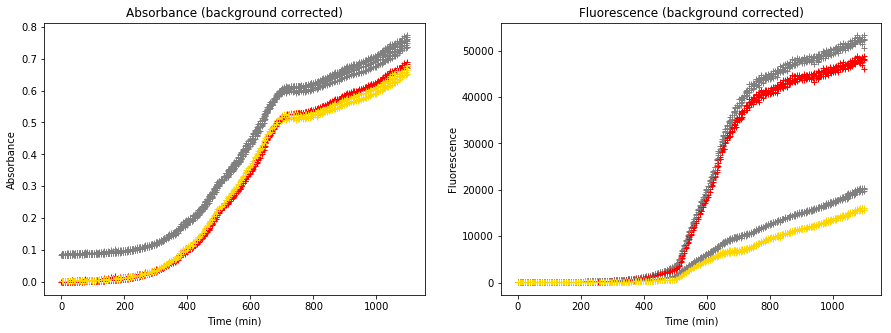

In [23]:
# Plot background corrected data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Absorbance (background corrected)')
ax[0].set_ylabel('Absorbance')
ax[0].set_xlabel('Time (min)')
ax[1].set_title('Fluorescence (background corrected)')
ax[1].set_ylabel('Fluorescence')
ax[1].set_xlabel('Time (min)')
for ir, r in enumerate(rows):
    for ic, c in enumerate(cols):
        wellname = r + str(c)
        wells[wellname]['Abs'].plot(
            ax=ax[0], marker='+', linewidth=1, linestyle='none', color='grey')
        wells[wellname]['Abs-corrected'].plot(
            ax=ax[0], marker='+', linewidth=1, linestyle='none', color=colors[ic])
        wells[wellname]['Fluo'].plot(
            ax=ax[1], marker='+', linewidth=1, linestyle='none', color='grey')
        wells[wellname]['Fluo-corrected'].plot(
            ax=ax[1], marker='+', linewidth=1, linestyle='none', color=colors[ic])
plt.show()

In [24]:
# parameters
eps_L = 1e-7
dR = .00065  # Reporter degradation rate (mn-1)
dP = .00065  # Proteins degradation rate (mn-1)

In [27]:
for ir, r in enumerate(rows):
    for ic, c in enumerate(cols):
        # For Absorbance
        wellname = r + str(c)
        print('Conputing ' + wellname)

        xmin, xmax = wells[wellname]["Abs-corrected"].xlim()
        ttu = np.arange(xmin, xmax, 3)[:-5]

        # Growth Rate
        wells[wellname]["gr"], _, _, _, _ = wf.infer_growth_rate(
            wells[wellname]["Abs-corrected"], ttu, eps_L=eps_L)

        # Compute promoter activity
        wells[wellname]["prom-act"], _, _, _, _ = wf.infer_synthesis_rate_onestep(
            wells[wellname]["Fluo-corrected"], wells[wellname]["Abs-corrected"],
            ttu, degr=dP, eps_L=eps_L)

        # Compute protein concentration
        wells[wellname]["prot-conc"], _, _, _, _ = wf.infer_prot_conc_onestep(
            wells[wellname]["Fluo-corrected"], wells[wellname]["Abs-corrected"],
            ttu, dR=dR, dP=dP, eps_L=eps_L)

        # Compute reporter concentration
        xmin_abso, xmax_abso = wells[wellname]["Abs-corrected"].xlim()
        xmin_fluo, xmax_fluo = wells[wellname]["Fluo-corrected"].xlim()
        ttu = np.arange(max(xmin_abso, xmin_fluo),
                        min(xmax_abso, xmax_fluo), 3)[:-5]
        wells[wellname]["rep-conc"] = wf.curves.Curve(
            ttu, wells[wellname]["Fluo-corrected"](ttu) / wells[wellname]["Abs-corrected"](ttu))

Conputing E8
Conputing E12
Conputing F8
Conputing F12
Conputing G8
Conputing G12
Conputing H8
Conputing H12


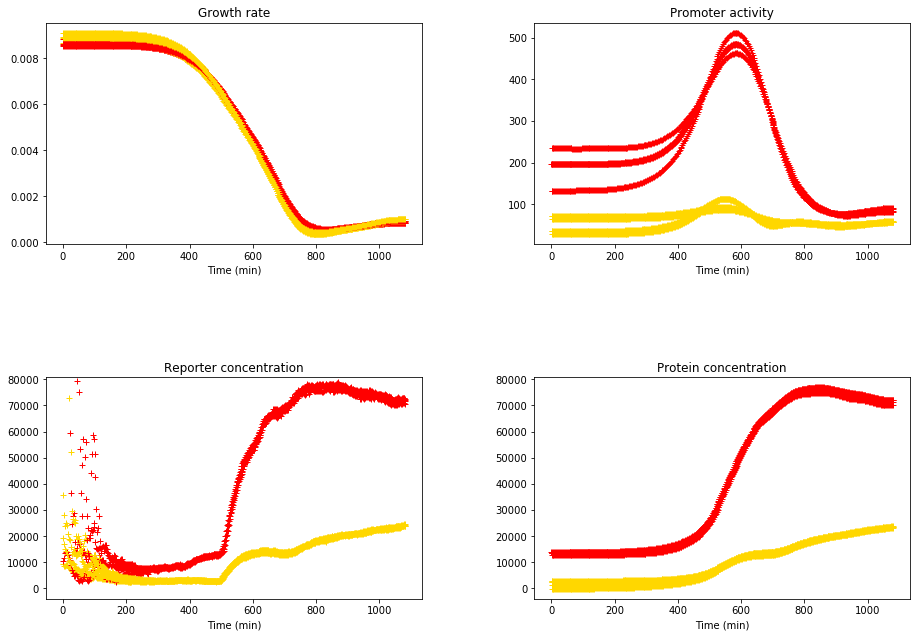

In [29]:
# Plot background corrected data
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(bottom=0.1, left=0.1, right=0.9,
                    top=0.9, wspace=0.3, hspace=0.6)

ax[0, 0].set_title('Growth rate')
ax[0, 0].set_xlabel('Time (min)')
ax[0, 1].set_title('Promoter activity')
ax[0, 1].set_xlabel('Time (min)')
ax[1, 0].set_title('Reporter concentration')
ax[1, 0].set_xlabel('Time (min)')
ax[1, 1].set_title('Protein concentration')
ax[1, 1].set_xlabel('Time (min)')

for ir, r in enumerate(rows):
    for ic, c in enumerate(cols):
        wellname = r + str(c)
        wells[wellname]['gr'].plot(
            ax=ax[0, 0], marker='+', linewidth=1, linestyle='none', color=colors[ic])
        wells[wellname]['prom-act'].plot(
            ax=ax[0, 1], marker='+', linewidth=1, linestyle='none', color=colors[ic])
        wells[wellname]['rep-conc'].plot(
            ax=ax[1, 0], marker='+', linewidth=1, linestyle='none', color=colors[ic])
        wells[wellname]['prot-conc'].plot(
            ax=ax[1, 1], marker='+', linewidth=1, linestyle='none', color=colors[ic])

ax[1, 0].set_ylim(ax[1, 1].get_ylim())
plt.show()